# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  At core, we will be constructing a model to classify _candidate_ CDR mentions as either true or false.

## Part IV: Training a Model with Data Programming

In this part of the tutorial, we will train a statistical model to differentiate between true and false `ChemicalDisease` mentions.

We will train this model using _data programming_, and we will **ignore** the training labels provided with the training data. This is a more realistic scenario; in the wild, hand-labeled training data is rare and expensive. Data programming enables us to train a model using only a modest amount of hand-labeled data for validation and testing. For more information on data programming, see the [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# Note: We run automated tests on this tutorial to make sure that it is always up to date! 
# However, certain interactive components cannot currently be tested automatically, and will 
# be skipped with if-then statements using the variable below
AUTOMATED_TESTING = os.environ.get('TESTING') is not None

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We repeat our definition of the `ChemicalDisease` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

## Loading `CandidateSet` objects

We reload the `CandidateSet` objects from the previous parts of the tutorial. Note that we will now process all three (training, validation, and test) as we go, because each plays a distinct role in Parts IV and V.

In [3]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
test = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Test Candidates').one()

candidate_sets = [train, dev, test]

## Creating Labeling Functions
Labeling functions are a core tool of data programming. They are heuristic functions that aim to classify candidates correctly. Their outputs will be automatically combined and denoised to estimate the probabilities of training labels for the training data.

## Inspecting some examples in the training set

We'll start here to come up with some ideas for LFs:

In [5]:
train_gold = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates -- Gold').one()
len(train_gold)

1745

In [6]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
if not AUTOMATED_TESTING:
    sv = SentenceNgramViewer(train_gold, session, annotator_name="Tutorial Part IV User")
else:
    sv = None

<IPython.core.display.Javascript object>

In [7]:
sv

In [8]:
c = sv.get_selected()
c

ChemicalDisease(Span("TRI", parent=3049, chars=[0,2], words=[0,0]), Span("hyperactivity", parent=3049, chars=[53,65], words=[8,8]))

## Traditional "distant supervision" as a single LF

See http://ctdbase.org/downloads/;jsessionid=5B8E7F187A4772BB9478B6B3D9FCA5D1#cd

**TODO: Make download script**

In [9]:
DATA_ROOT = os.environ['SNORKELHOME'] + '/tutorial/data/'

CTD_lower = set()
with open(DATA_ROOT + 'dicts/CTD_chemicals_diseases.tsv', 'rb') as f:
    for line in f:
        if not line.startswith("#"):
            chem, chem_id, _, disease, disease_id, evidence, _, _, _, _ = line.split('\t')
            CTD_lower.add((chem.lower(), disease.lower()))
print len(CTD_lower)

1914160


# LFs

In [10]:
from random import random
from snorkel.lf_helpers import get_text_between
from snorkel.models import split_stable_id
from snorkel.lf_helpers import get_tagged_text

def LF_in_CDT(c, p_neg=0.1):
    """Match against the CDT KB, with random negative supervision as well"""
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower:
        return 1
    else:
        return -1 if random() < p_neg else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'associated with', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

ANIMAL_RGX = r'mouse|mice'

def LF_animal(c):
    return -1 if re.search(ANIMAL_RGX, get_tagged_text(c), flags=re.I) else 0

def LF_cause(c):
    return 1 if re.search(r'cause', get_text_between(c), flags=re.I) else 0

def LF_in_CDT_causes(c):
    """Match against the CDT KB, with random negative supervision as well"""
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower:
        if re.search(r'causes', get_text_between(c), flags=re.I):
            return 1
    return 0

def LF_in_CDT_induced(c):
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower and re.search(r'{{A}}.{0,20}induce.{0,20}{{B}}', get_tagged_text(c), flags=re.I):
        return 1
    return 0

def LF_in_CDT_exposure(c):
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower and re.search(r'{{B}}.{0,20}expos.{0,20}{{A}}', get_tagged_text(c), flags=re.I):
        return 1
    return 0

def LF_in_CDT_caused_by(c):
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower and re.search(r'{{B}}.{0,20}caused by.{0,20}{{A}}', get_tagged_text(c), flags=re.I):
        return 1
    return 0

def LF_in_CDT_caused_by_2(c):
    chem    = c.chemical.get_span().lower()
    disease = c.disease.get_span().lower()
    if (chem, disease) in CTD_lower and re.search(r'{{B}}.*(caused|induced) by.*{{A}}', get_tagged_text(c), flags=re.I):
        return 1
    return 0

In [18]:
from snorkel.lf_helpers import get_matches

matches = get_matches(LF_weak_assertions, train)
print len(set(matches).intersection(train_gold))

892 matches
178


## Collecting LFs...

In [19]:
LFs = [
    LF_weak_assertions,
    LF_animal, 
    LF_in_CDT_causes,
    LF_in_CDT_induced,
    LF_in_CDT_caused_by_2
]

## Applying Labeling Functions

First we construct a `CandidateLabeler`.

In [20]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

Next we run the `CandidateLabeler` to to apply the labeling functions to the training `CandidateSet`.

In [21]:
%time L = label_manager.create(session, train, 'LF Labels 1', f=LFs)
L

[========================================] 100%

CPU times: user 41.3 s, sys: 3.51 s, total: 44.8 s
Wall time: 42.2 s


<6311x5 sparse matrix of type '<type 'numpy.float64'>'
	with 1237 stored elements in Compressed Sparse Row format>

We can view statistics about the resulting label matrix:

In [22]:
L.lf_stats()

,conflicts,coverage,j,overlaps
LF_weak_assertions,0.001426,0.141341,0,0.002852
LF_animal,0.000951,0.043258,1,0.002377
LF_in_CDT_causes,0.000317,0.000317,2,0.000317
LF_in_CDT_induced,0.000951,0.004437,3,0.000951
LF_in_CDT_caused_by_2,0.000951,0.006655,4,0.000951


## Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

In [28]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L)

Training marginals (!= 0.5):	6311
Features:			5
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.008363
	Learning epoch = 250	Gradient mag. = 0.008724
	Learning epoch = 500	Gradient mag. = 0.008652
	Learning epoch = 750	Gradient mag. = 0.008585
Final gradient magnitude for rate=0.01, mu=1e-06: 0.009


In [29]:
gen_model.w

array([ 0.98244017,  1.00873864,  0.98375448,  0.94650812,  0.93690132])

In [26]:
gen_model.save(session, 'Generative Params 1')

In [27]:
gen_model.load(session, 'Generative Params 2')
gen_model.w

array([], dtype=float64)

We now apply the generative model to the training candidates.

In [30]:
train_marginals = gen_model.marginals(L)

Calibration plot:


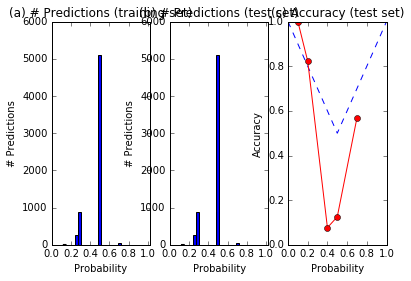

Test set size:	6311
----------------------------------------
Pos. class accuracy: 0.0372881355932
Neg. class accuracy: 0.995392554368
----------------------------------------
Precision:	0.568965517241
Recall:		0.0372881355932
F1 Score:	0.0699893955461
----------------------------------------
TP: 33 | FP: 25 | TN: 5401 | FN: 852
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0189111747851
Neg. class accuracy: 0.995392554368
Corpus Precision 0.569
Corpus Recall    0.0189
Corpus F1        0.0366
----------------------------------------
TP: 33 | FP: 25 | TN: 5401 | FN: 1712



In [41]:
train_labels   = label_manager.load(session, train, "CDR Training Labels -- Gold")
train_gold_set = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates -- Gold').one()
tp, fp, tn, fn = gen_model.score(L, train_labels, train_gold_set)

## Training the Discriminative Model
We use the estimated probabilites to train a discriminative model that classifies each `Candidate` as a true or false mention.

In [ ]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F, train_marginals, n_iter=1500, rate=1e-5)

In [ ]:
disc_model.w.shape

In [ ]:
%time disc_model.save(session, "Discriminative Params 1")

In [ ]:
w_prev = disc_model.w
%time disc_model.load(session, "Discriminative Params 1")
np.all(disc_model.w == w_prev)

## Evaluating on the Development `CandidateSet`

In [ ]:
test_labels=[]
for candidate in sorted_test_candidates:
    test_labels.append(1 if candidate in gold_candidate_set else -1)
test_labels = np.asarray(test_labels)

score(sorted_test_candidates, test_labels, pred, gold_candidate_set, \
      train_marginals=train_marginals, test_marginals=test_marginals)

After evaluating on the development `CandidateSet`, the labeling functions can be modified. Try changing the labeling functions to improve performance. You can view the true positives, false positives, true negatives, and false negatives using the `Viewer`.

## Saving the Discriminative Model's Parameters
We save the model's parameters for use in Part V.

Next, in Part V, we will test our model on the test `CandidateSet`.